# Skin diseases prediction using various deep neural networks
Here, I will be implementing various deep learning architectures to classify thirteen different types of skin diseases.
The target of this experiment is to compare various models on various parameters to draw possible conclusions about architectures.
Models implemented here are:
1. TinyVGG (without augmentation)
2. TinyVGG (with augmentation)
3. MobileNet
4. DenseNet
5. VGG19
6. Vision Transformers
<br>
As data is medical data, it is difficult to generate synthetic data which accurately represents specific diseases. That is why, I will be using resampling if required. Transfer learning will be used for some models while some will be trained from scratch.
<br>
Experiment is designed in a way that code can be understood easily with well written documentation following all methods of writing code suggested in PEP 8 style of python programming.
<br>
As this is experiment setup, code is in notebook. Once results are derived, code can be converted in modular format and packaged to be delievered for easy usage.

## 0. Setting up machine for experiment

In [39]:
import torch
from torch import nn

torch.__version__

'2.0.0+cu117'

Now, as experiment should run on both CPU as well as GPU machines, I will set device which can be done directly with PyTorch.

In [40]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

I have GPU set in my machine which is represented by CUDA in PyTorch (CUDA is NVIDIA GPU computing toolkit).

## 1. Setting up data
As I am working on skin disease dataset, I need to use custom dataset (There is no pre-loaded dataset in PyTorch for this specific as per my knowledge.). I will be writing my own dataset process function which will be inherited from Dataset module of PyTorch so I get some pre-built functionality from module directly.
<br>
Format of data is:
|Dataset<br>
|--train<br>
|--|--Disease 1<br>
|--|--|--img_1.png<br>
|--|--|--img_2.png<br>
|--|--|--  &ensp;  .<br>
|--|--|--  &ensp;  .<br>
|--|--Disease 2<br>
|--|--|--img_1.png<br>
|--|--|--img_2.png<br>
|--|--|--    &ensp;.<br>
|--|--|--    &ensp;.<br>
|--|--   &ensp; .<br>
|--|--   &ensp; .<br>
|--|--Disease 9<br>
|--|--|--img_1.png<br>
|--|--|--img_2.png<br>
|--|--|--  &ensp;  .<br>
|--|--|--  &ensp;  .<br>
|--test<br>
|--|--Disease 1<br>
|--|--|--img_1.png<br>
|--|--|--img_2.png<br>
|--|--|--  &ensp;  .<br>
|--|--|--  &ensp;  .<br>
|--|--Disease 2<br>
|--|--|--img_1.png<br>
|--|--|--img_2.png<br>
|--|--|--  &ensp;  .<br>
|--|--|--  &ensp;  .<br>
|--|--  &ensp;  .<br>
|--|--  &ensp;  .<br>
|--|--Disease 9<br>
|--|--|--img_1.png<br>
|--|--|--img_2.png<br>
|--|--|--   &ensp; .<br>
|--|--|--   &ensp; .<br>

In [41]:
import os

def walk_through_dir(dir_path):
    """
    Walks through dir_path returning its contents.
    Args:
    dir_path (str or pathlib.Path): target directory

    Returns:
    A print out of:
        number of subdiretories in dir_path
        number of images (files) in each subdirectory
        name of each subdirectory
    """
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [42]:
walk_through_dir('Dataset')

There are 2 directories and 0 images in 'Dataset'.
There are 13 directories and 0 images in 'Dataset\test'.
There are 0 directories and 231 images in 'Dataset\test\Acne and Rosacea Photos'.
There are 0 directories and 120 images in 'Dataset\test\Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions'.
There are 1 directories and 24 images in 'Dataset\test\Atopic Dermatitis Photos'.
There are 0 directories and 204 images in 'Dataset\test\Atopic Dermatitis Photos\Acne and Rosacea Photos'.
There are 0 directories and 14 images in 'Dataset\test\Cellulitis Impetigo and other Bacterial Infections'.
There are 0 directories and 30 images in 'Dataset\test\Light Diseases and Disorders of Pigmentation'.
There are 0 directories and 25 images in 'Dataset\test\Lupus and other Connective Tissue diseases'.
There are 0 directories and 13 images in 'Dataset\test\Poison Ivy Photos and other Contact Dermatitis'.
There are 0 directories and 24 images in 'Dataset\test\Psoriasis pictures Lichen P

We have different number of images per class but we will decide its effect once we train few models. Till than we will go with augmentations only.

In [43]:
from pathlib import Path

image_path = Path('Dataset/')
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('Dataset/train'), WindowsPath('Dataset/test'))

### 1.1 Visualization of data
Here, I will be writing function to visualize random image from dataset.

3141
Random image path: Dataset\train\Systemic Disease\neurofibromatosis-10.jpg
Image class: Systemic Disease
Image height: 476
Image width: 720


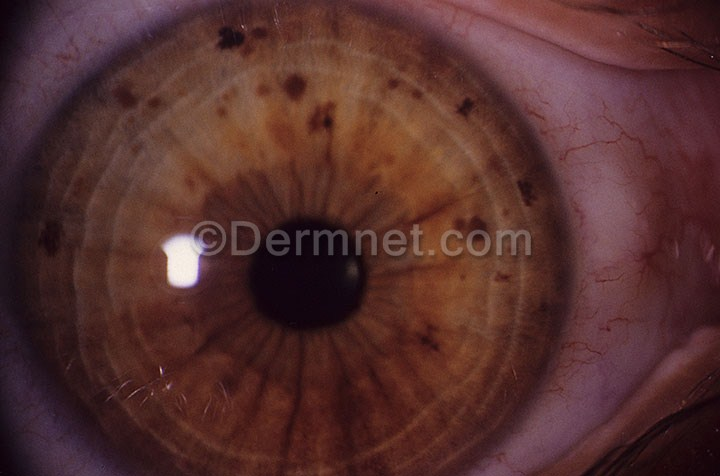

In [44]:
import random
from PIL import Image

random.seed(42)

image_path_list = list(image_path.glob("*/*/*.jpg"))
print(len(image_path_list))

random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

## 2. Transforming data
Converting images to tensors.<br>
Loading them to Dataset and in Dataloader.

In [45]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [46]:
data_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

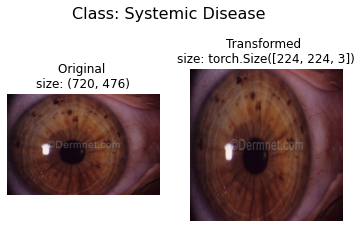

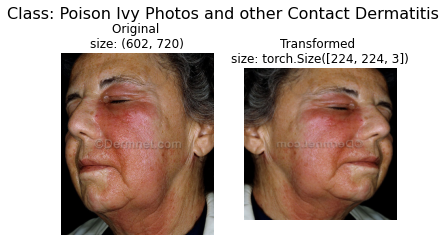

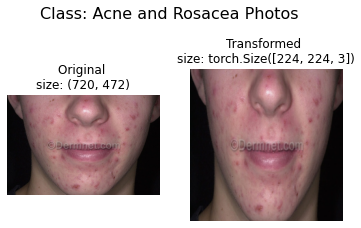

In [47]:
import matplotlib.pyplot as plt

def viz_trans_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1,2)
            ax[0].imshow(f)
            width, height = f.size
            ax[0].set_title(f"Original \nsize: {width, height}")
            ax[0].axis("off")

            transformed_image = transform(f).permute(1,2,0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nsize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

viz_trans_images(image_path_list, transform=data_transform, n=3)

In [48]:
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 2472
    Root location: Dataset\train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 873
    Root location: Dataset\test


In [49]:
class_names = train_data.classes
class_names

['Acne and Rosacea Photos',
 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions',
 'Atopic Dermatitis Photos',
 'Cellulitis Impetigo and other Bacterial Infections',
 'Light Diseases and Disorders of Pigmentation',
 'Lupus and other Connective Tissue diseases',
 'Poison Ivy Photos and other Contact Dermatitis',
 'Psoriasis pictures Lichen Planus and related diseases',
 'Seborrheic Keratoses and other Benign Tumors',
 'Systemic Disease',
 'Tinea Ringworm Candidiasis and other Fungal Infections',
 'Vascular Tumors',
 'Warts Molluscum and other Viral Infections']

In [50]:
class_dict = train_data.class_to_idx
class_dict

{'Acne and Rosacea Photos': 0,
 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions': 1,
 'Atopic Dermatitis Photos': 2,
 'Cellulitis Impetigo and other Bacterial Infections': 3,
 'Light Diseases and Disorders of Pigmentation': 4,
 'Lupus and other Connective Tissue diseases': 5,
 'Poison Ivy Photos and other Contact Dermatitis': 6,
 'Psoriasis pictures Lichen Planus and related diseases': 7,
 'Seborrheic Keratoses and other Benign Tumors': 8,
 'Systemic Disease': 9,
 'Tinea Ringworm Candidiasis and other Fungal Infections': 10,
 'Vascular Tumors': 11,
 'Warts Molluscum and other Viral Infections': 12}

In [51]:
# BATCH_SIZE = 32
# NUM_WORKERS = os.cpu_count()

# train_dataloader = DataLoader(dataset=train_data,
#                               batch_size=BATCH_SIZE,
#                               num_workers=NUM_WORKERS,
#                               shuffle=True)

# test_dataloader = DataLoader(dataset=test_data,
#                              batch_size=BATCH_SIZE,
#                              num_workers=NUM_WORKERS,
#                              shuffle=False)
# train_dataloader, test_dataloader

In [53]:
# img, label = next(iter(train_dataloader))

# print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
# print(f"Label shape: {label.shape}")

## Model 1: TinyVGG without data augmentation